In [220]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn as sk
import datetime

%load_ext tensorboard

filename = './_data/filtered_data.csv'
data = pd.read_csv('./_data/filtered_data.csv')

data = data.drop(['Unnamed: 0'],axis=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## NN Model Training
----

Before training the model, we want to do some further preprocessing such as normalizaiton and ensuring the datatype of each column is float type. 

In [221]:
from sklearn.model_selection import train_test_split

def model_preprocessing(dataset,date_range,test_size):
    """
    Takes filtered dataset and returns train_test_split dataset for training model. Removes columns of dtype == "object".
    
    :dataset: input dataset (pd.DataFrame type)
    :seasons: range of seasons eg. ("2016-01-01","2019-01-01")
    :test_size: validation set size
    """
    
    seasonal_data = dataset.loc[np.where((dataset['Date'] > date_range[0]) & (dataset['Date'] < date_range[1]))]
    
    column_ind = [i for i in range(0,len(dataset.dtypes)) if dataset.dtypes[i] == 'object']
    seasonal_data = seasonal_data.drop(columns = seasonal_data.columns[column_ind], axis = 1)
    
    OU_classification = np.asarray(seasonal_data['O/U'])
    
    seasonal_data = seasonal_data.drop(columns = ['O/U'], axis = 1)
    seasonal_data = np.asarray(seasonal_data, dtype = float)   
    seasonal_data = keras.utils.normalize(seasonal_data, axis=1)
     
    return train_test_split(seasonal_data, OU_classification, random_state=42,test_size = test_size)

def prediction_classifier(prediction):
    outcome=[]
    for pred in prediction:
        outcome.append(float(pred.argmax()))
        
    return outcome

X_train, X_test, y_train, y_test = model_preprocessing(dataset = data.drop(columns = ['Total'],axis = 1),
                                                       date_range = ("2012-01-01", "2029-01-01"),
                                                       test_size = 0.2)
    

We will use a two fully connected layer with a flatten layer and a dropout layer in between. 

In [248]:
#tensorboard
log_dir = "./_data/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#earling stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#model checkpoint
checkpoint_filepath = './_data/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    

model = tf.keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(tf.keras.layers.Dense(128, activation="relu6"))
model.add(keras.layers.Dropout(0.2) )
model.add(tf.keras.layers.Dense(3, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [249]:
model.fit(X_train, 
          y_train, 
          epochs=60, 
          validation_split=0.1, 
          batch_size=60,
          callbacks=[callback,tensorboard_callback,model_checkpoint_callback])

Epoch 1/60
96/96 [==============================] - 1s 10ms/step - loss: 0.8112 - accuracy: 0.4925 - val_loss: 0.7555 - val_accuracy: 0.7445
Epoch 2/60
96/96 [==============================] - 1s 9ms/step - loss: 0.7415 - accuracy: 0.5401 - val_loss: 0.7415 - val_accuracy: 0.6019
Epoch 3/60
96/96 [==============================] - 1s 10ms/step - loss: 0.7273 - accuracy: 0.6121 - val_loss: 0.7224 - val_accuracy: 0.7884
Epoch 4/60
96/96 [==============================] - 1s 9ms/step - loss: 0.6992 - accuracy: 0.6982 - val_loss: 0.6920 - val_accuracy: 0.8135
Epoch 5/60
96/96 [==============================] - 1s 8ms/step - loss: 0.6696 - accuracy: 0.7318 - val_loss: 0.6563 - val_accuracy: 0.8072
Epoch 6/60
96/96 [==============================] - 1s 8ms/step - loss: 0.6235 - accuracy: 0.7778 - val_loss: 0.6083 - val_accuracy: 0.8276
Epoch 7/60
96/96 [==============================] - 1s 8ms/step - loss: 0.5814 - accuracy: 0.7954 - val_loss: 0.5793 - val_accuracy: 0.7884
Epoch 8/60
96/96 [

Below cell runs TensorBoard with information such as epoch_accuracy and epoch_loss graphs

In [252]:
%tensorboard --logdir _data/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
E0512 16:07:41.398544 8176745088 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/Users/logange/miniforge3/envs/tensorflow_silicon/lib/python3.9/site-packages/tensorboard/backend/application.py", line 123, in TensorBoardWSGIApp
    plugin = loader.load(context)
  File "/Users/logange/miniforge3/envs/tensorflow_silicon/lib/python3.9/site-packages/tensorboard_plugin_wit/wit_plugin_loader.py", line 57, in load
    from tensorboard_plugin_wit.wit_plugin import WhatIfToolPlugin
  File "/Users/logange/miniforge3/envs/tensorflow_silicon/lib/python3.9/site-packages/tensorboard_plugin_wit/wit_plugin.py", line 40, in <module>
    from tensorboard_plugin_wit._utils import common_utils
  File "/Users/logange/miniforge3/envs/tensorflow_silicon/lib/python3.9/site-packages/tensorboard_plugin_wit/_utils/common_utils.py", line 17, in <module>
    from t

## Evaluating Model Performance

In [228]:
prediction_output = model.predict(X_test)
predictions = prediction_classifier(prediction_output)

50/50 [==============================] - 0s 2ms/step


<Figure size 576x504 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion matrix')

Text(51.0, 0.5, 'True')

Text(0.5, 42.0, 'Predicted')

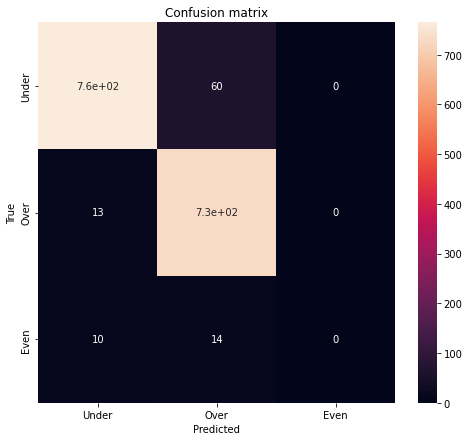

In [229]:
confusion_matrix = sk.metrics.confusion_matrix(y_test,predictions)
outcomes = ['Under','Over','Even']

df_cm = pd.DataFrame(confusion_matrix, index = outcomes, columns = outcomes)
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True)

plt.title('Confusion matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.show()

We see that even after removing the total score, advanced offensive/defensive boxscore statistics provide strong predictive power in determining whether the resulting game score is over or under the bookkeeper's initial O/U line. We  are successful for up to 93.73% with in game statistics. A more accurate model would be to use the averaged statistics from the previous 5 games to more accurately model real-life betting conditions. 

However, our model tells us that offensive/defensive pace and efficiency are very important predictors for O/U betting.